# Titanic. Survived model.

Это легендарное соревнование Titanic ML.

Соревнование простое: используйте машинное обучение, чтобы создать модель, которая предсказывает, какие пассажиры выжили после кораблекрушения Титаника.

[Вся информация здесь](https://www.kaggle.com/competitions/titanic/overview)

## Загрузка данных

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# импорт необходимых библиотек для работы
import pandas as pd
# import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklift.models import ClassTransformation
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, r2_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

random_state = 42

In [3]:
# загрузка данных
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')

In [4]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non

(None, None)

In [5]:
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
display(train.head()) 
test.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
display(train.isna().mean())
test.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

In [8]:
# приведем названия столбцов к нижнему регистру
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

## Исследовательский анализ

Попробуем описать потрет выжившего в трагедии с Титаником.

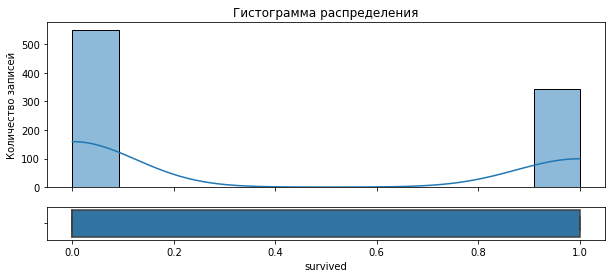

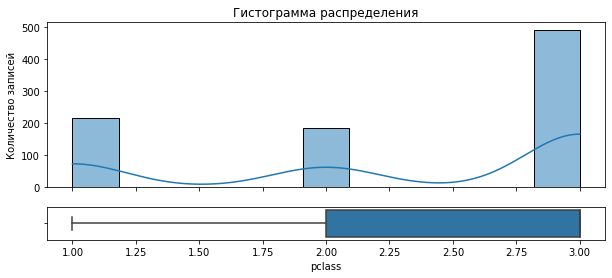

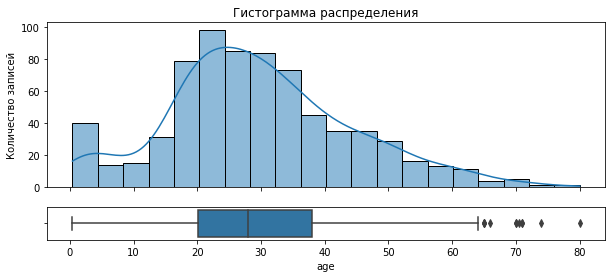

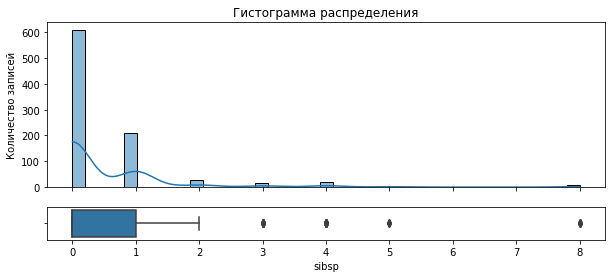

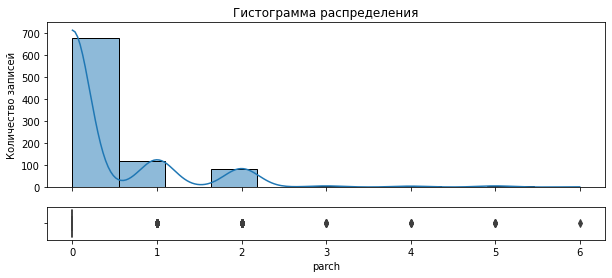

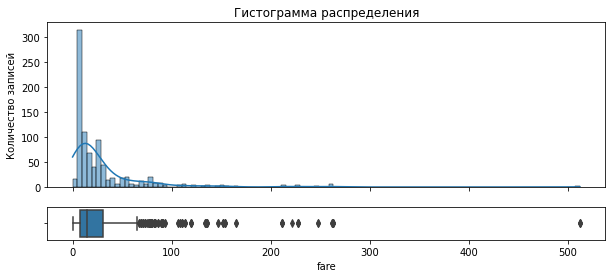

In [9]:
# функция для изучения выбросов и аномалий в данных
def boxplot_table(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist)
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');
# цикл для посьроения графиков по всем полям цифровым
for col in train.select_dtypes(include='number').columns:
    boxplot_table(train, col)

In [10]:
# функция для изучения распределения данных по целевому признаку
def result_table(data, column):
    table = (data.groupby(column)['survived'].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')
    return table

In [11]:
col = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
for c in col:
    display(result_table(train, c))

,sum,count,share
pclass,,,
1,136,216,0.629630
2,87,184,0.472826
3,119,491,0.242363


,sum,count,share
sex,,,
female,233,314,0.742038
male,109,577,0.188908


,sum,count,share
sibsp,,,
1,112,209,0.535885
2,13,28,0.464286
0,210,608,0.345395
3,4,16,0.250000
4,3,18,0.166667
5,0,5,0.000000
8,0,7,0.000000


,sum,count,share
parch,,,
3,3,5,0.600000
1,65,118,0.550847
2,40,80,0.500000
0,233,678,0.343658
5,1,5,0.200000
4,0,4,0.000000
6,0,1,0.000000


,sum,count,share
embarked,,,
C,93,168,0.553571
Q,30,77,0.389610
S,217,644,0.336957


In [12]:
# функция для перевода поля в бинарное значение
train['cabin'] = train['cabin'].fillna('NNN')
test['cabin'] = test['cabin'].fillna('NNN')
def cabin_make(row):
    cabin = row['cabin']
    if cabin == 'NNN':
        return 0
    else:
        return 1
# прмиеним функцию    
train['cabin'] = train.apply(cabin_make, axis=1) 
test['cabin'] = test.apply(cabin_make, axis=1) 

In [13]:
result_table(train, 'cabin')

,sum,count,share
cabin,,,
1,136,204,0.666667
0,206,687,0.299854


In [14]:
train.corr().style.background_gradient(low=0.1, cmap='YlOrRd')

,survived,pclass,age,sibsp,parch,fare,cabin
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.316912
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.725541
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.249732
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.040460
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.036987
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.482075
cabin,0.316912,-0.725541,0.249732,-0.040460,0.036987,0.482075,1.000000


In [15]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


## Подготовка данных

In [16]:
# функция для замены пропусков в возрасте
def age_fillna(row):
    sex = row['sex']
    pcclass = row['pclass']
    if sex == 'female':
        if pcclass == 1:
            return 34.611765
        elif pcclass == 2:
            return 28.722973
        else:
            return 21.75
            
    elif sex == 'male':
        if pcclass == 1:
            return 41.281386
        elif pcclass == 2:
            return 30.740707
        else:
            return 26.507589

In [17]:
# функция для подготовки сетов
def make_df(table, chek):
    df = table.copy()
    # заменим пропуски
    df['embarked'] = df['embarked'].fillna('N')
    df['age'] = df['age'].fillna(df.apply(age_fillna, axis=1))
    # добавим категорию
#     df['age_cat'] = pd.qcut(df.age, 10, labels=range(1, 11))
    df['title'] = df['name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
#     сменим тип данных
    for c in df.select_dtypes(include=['object', 'category']).columns:
        df[c] = df[c].astype('category')
        
    # удалим лишние колонки
    X_df = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title']]
#     X_df = df[['age', 'fare', 'embarked', 'title']]
    if chek == 0:
        y_df = df[['survived']]
        return X_df, y_df
    else:
        return X_df

In [18]:
X_df, y_df = make_df(train, 0)
X_test = make_df(test, 1)

In [19]:
X_test.isna().mean()

pclass      0.000000
sex         0.000000
age         0.000000
sibsp       0.000000
parch       0.000000
fare        0.002392
cabin       0.000000
embarked    0.000000
title       0.000000
dtype: float64

In [20]:
X_test.loc[X_test['fare'].isna(), 'fare'] = X_test.query('pclass == 3 and embarked == "S"')['fare'].mean()

In [21]:
X_df.shape, y_df.shape, X_test.shape

((891, 9), (891, 1), (418, 9))

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.25, random_state=random_state)

In [23]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 9), (668, 1), (223, 9), (223, 1))

## Подбор моделей

In [29]:
models_results = {
            'model': [],
            'best_score': [],
            'accurasy': []
        }

In [25]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=random_state)

### Catboost

In [26]:
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)
cat_features.append('cabin')

In [27]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 100)
cbc = CatBoostClassifier(random_state=random_state
                         , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='accuracy', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6884484	test: 0.6888831	test1: 0.6894042	best: 0.6894042 (0)	total: 105ms	remaining: 41.9s
100:	learn: 0.4498291	test: 0.4650978	test1: 0.4820887	best: 0.4820887 (100)	total: 7.07s	remaining: 20.9s
200:	learn: 0.3726553	test: 0.4094612	test1: 0.4463871	best: 0.4463871 (200)	total: 19.5s	remaining: 19.3s
300:	learn: 0.3289144	test: 0.3875385	test1: 0.4390129	best: 0.4387761 (297)	total: 37.5s	remaining: 12.3s
399:	learn: 0.2976871	test: 0.3747113	test1: 0.4358511	best: 0.4357515 (384)	total: 55.5s	remaining: 0us

bestTest = 0.4357515397
bestIteration = 384

Shrink model to first 385 iterations.
0:	learn: 0.6887627	test: 0.6889428	test1: 0.6894651	best: 0.6894651 (0)	total: 21.4ms	remaining: 8.55s
100:	learn: 0.4598426	test: 0.4718607	test1: 0.4774241	best: 0.4774241 (100)	total: 6.1s	remaining: 18.1s
200:	learn: 0.3876266	test: 0.4203472	test1: 0.4378097	best: 0.4378097 (200)	total: 14.9s	remaining: 14.8s
300:	learn: 0.3415776	test: 0.3966413	test1: 0.4260213	best: 0.4258961

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7efee367e090>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='accuracy')

In [30]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8431137724550899,
 {'learning_rate': 0.01, 'l2_leaf_reg': 6, 'iterations': 200, 'depth': 16})

In [31]:
best_cbc.fit(X_train, y_train)

pred = best_cbc.predict(X_val)
predict = best_cbc.predict_proba(X_val)[:, 1]

0:	learn: 0.6870610	total: 4.42ms	remaining: 880ms
1:	learn: 0.6805280	total: 8.97ms	remaining: 888ms
2:	learn: 0.6750868	total: 11.6ms	remaining: 765ms
3:	learn: 0.6697140	total: 16.4ms	remaining: 803ms
4:	learn: 0.6641225	total: 22.5ms	remaining: 877ms
5:	learn: 0.6592787	total: 25.3ms	remaining: 820ms
6:	learn: 0.6539009	total: 30ms	remaining: 828ms
7:	learn: 0.6507644	total: 32.4ms	remaining: 777ms
8:	learn: 0.6478419	total: 34.1ms	remaining: 723ms
9:	learn: 0.6435696	total: 37.9ms	remaining: 721ms
10:	learn: 0.6384359	total: 41.2ms	remaining: 709ms
11:	learn: 0.6338461	total: 50.7ms	remaining: 794ms
12:	learn: 0.6297732	total: 54.6ms	remaining: 785ms
13:	learn: 0.6252595	total: 56.8ms	remaining: 754ms
14:	learn: 0.6213512	total: 63.2ms	remaining: 780ms
15:	learn: 0.6175619	total: 72.8ms	remaining: 837ms
16:	learn: 0.6135753	total: 87.5ms	remaining: 942ms
17:	learn: 0.6113440	total: 89.9ms	remaining: 909ms
18:	learn: 0.6077553	total: 92.8ms	remaining: 884ms
19:	learn: 0.6033387	tot

In [32]:
from catboost.utils import get_roc_curve, select_threshold

catboost_pool = Pool(X_train, y_train, cat_features=cat_features)
roc_curve_values = get_roc_curve(best_cbc, catboost_pool)

best_score = 0
it = 0
best_boundary = 0

for i in range(1, 100, 1):
    boundary = select_threshold(best_cbc, 
                            curve=roc_curve_values,  
                            FPR=i/100)
    predicted = (predict >= boundary)*1
    if accuracy_score(predicted, y_val) > best_score:
        best_score = accuracy_score(predicted, y_val)
        it = i
        best_boundary = boundary

best_score, it, best_boundary

(0.820627802690583, 2, 0.7107962817703868)

In [33]:
predicted = (predict >= best_boundary)*1

In [34]:
accuracy_score(pred, y_val), accuracy_score(predicted, y_val)

(0.8026905829596412, 0.820627802690583)

In [36]:
models_results['model'].append(grid_cbc.best_estimator_)
models_results['best_score'].append(grid_cbc.best_score_)
models_results['accurasy'].append(accuracy_score(predicted, y_val))

In [37]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,title,28.373106
1,pclass,21.460149
2,sex,12.116993
3,embarked,9.022473
4,fare,8.996022
5,cabin,7.451192
6,age,5.802144
7,sibsp,4.651653
8,parch,2.126268


### LGBM

In [38]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 100)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='accuracy', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

[100]	valid_0's binary_logloss: 0.537147	valid_1's binary_logloss: 0.549947
[100]	valid_0's binary_logloss: 0.540804	valid_1's binary_logloss: 0.553479
[100]	valid_0's binary_logloss: 0.53044	valid_1's binary_logloss: 0.555288
[100]	valid_0's binary_logloss: 0.537409	valid_1's binary_logloss: 0.550182
[100]	valid_0's binary_logloss: 0.534774	valid_1's binary_logloss: 0.551518
[100]	valid_0's binary_logloss: 0.619342	valid_1's binary_logloss: 0.625657
[200]	valid_0's binary_logloss: 0.598758	valid_1's binary_logloss: 0.60612
[300]	valid_0's binary_logloss: 0.565359	valid_1's binary_logloss: 0.574751
[400]	valid_0's binary_logloss: 0.5473	valid_1's binary_logloss: 0.55793
[100]	valid_0's binary_logloss: 0.622332	valid_1's binary_logloss: 0.626358
[200]	valid_0's binary_logloss: 0.602146	valid_1's binary_logloss: 0.607735
[300]	valid_0's binary_logloss: 0.569216	valid_1's binary_logloss: 0.578088
[400]	valid_0's binary_logloss: 0.551078	valid_1's binary_logloss: 0.562108
[100]	valid_0's b

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='accuracy')

In [39]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8347305389221557,
 {'num_leaves': 175,
  'n_estimators': 840,
  'max_depth': 28,
  'learning_rate': 0.1,
  'boosting_type': 'goss'})

In [40]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)

In [41]:
models_results['model'].append(grid_lgbm.best_estimator_)
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['accurasy'].append(accuracy_score(pred, y_val))

In [42]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,fare,2407
1,age,2107
2,embarked,349
3,sex,288
4,sibsp,224
5,pclass,216
6,parch,139
7,cabin,131
8,title,1


### RandomForestClassifier

In [43]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
PassengerId,,,,,,,,,
299,1,male,41.281386,0,0,30.5000,1,S,Mr
885,3,male,25.000000,0,0,7.0500,0,S,Mr
248,2,female,24.000000,0,2,14.5000,0,S,Mrs
479,3,male,22.000000,0,0,7.5208,0,S,Mr
306,1,male,0.920000,1,2,151.5500,1,S,Master


In [44]:
X_train = pd.get_dummies(X_train, columns=['sex', 'embarked', 'title'], drop_first= True)
X_val = pd.get_dummies(X_val, columns=['sex', 'embarked', 'title'], drop_first= True)
X_test = pd.get_dummies(X_test, columns=['sex', 'embarked', 'title'], drop_first= True)
X_df = pd.get_dummies(X_df, columns=['sex', 'embarked', 'title'], drop_first= True)
X_train.shape, X_val.shape, X_test.shape, X_df.shape

((668, 26), (223, 26), (418, 17), (891, 26))

In [45]:
for c in list(set(X_df.columns) - set(X_test.columns)):
    X_test[c] = 0
X_test = X_test.drop('title_ Dona', axis=1)
X_train.shape, X_val.shape, X_test.shape, X_df.shape

((668, 26), (223, 26), (418, 26), (891, 26))

In [46]:
ss = StandardScaler() 
X_train = ss.fit_transform(X_train) 
X_val = ss.fit_transform(X_val) 
X_test = ss.fit_transform(X_test) 
X_df = ss.fit_transform(X_df)

In [47]:
rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced')

params = {'n_estimators': range(100, 1001, 100),
          'max_depth': range(1, 24, 1),
          'min_samples_split': range(1,10,1),
          'min_samples_leaf': range(1,10,1)
         }

grid_cv = RandomizedSearchCV(rfc, params, scoring='accuracy', cv=cv)
grid_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'max_depth': range(1, 24),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 10),
                                        'n_estimators': range(100, 1001, 100)},
                   scoring='accuracy')

In [48]:
best_rfc = grid_cv.best_estimator_
grid_cv.best_score_, grid_cv.best_params_

(0.8395209580838323,
 {'n_estimators': 500,
  'min_samples_split': 8,
  'min_samples_leaf': 5,
  'max_depth': 23})

In [49]:
best_rfc.fit(X_train, y_train)
pred = best_rfc.predict(X_val)

In [51]:
models_results['model'].append('best_rfc')
models_results['best_score'].append(grid_cv.best_score_)
models_results['accurasy'].append(accuracy_score(pred, y_val))

## Тестирование

In [52]:
pd.DataFrame(data=models_results).sort_values('accurasy', ascending=False)

,model,best_score,accurasy
0,<catboost.core.CatBoostClassifier object at 0x...,0.843114,0.820628
2,best_rfc,0.839521,0.820628
1,"LGBMClassifier(boosting_type='goss', class_wei...",0.834731,0.762332


In [53]:
X_df, y_df = make_df(train, 0)
X_test = make_df(test, 1)
X_test.loc[X_test['fare'].isna(), 'fare'] = X_test.query('pclass == 3 and embarked == "S"')['fare'].mean()
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.25, random_state=random_state)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 9), (668, 1), (223, 9), (223, 1))

In [54]:
# обучим модель на всех данных
best_cbc.fit(X_df, y_df)
# сделаем предсказания на тестовых данных
# predicted = best_rfc.predict(X_test)
predicted = (best_cbc.predict_proba(X_test)[:, 1] >= best_boundary)*1
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

0:	learn: 0.6876985	total: 3.72ms	remaining: 741ms
1:	learn: 0.6824316	total: 7.6ms	remaining: 753ms
2:	learn: 0.6781624	total: 9.95ms	remaining: 653ms
3:	learn: 0.6732757	total: 20.5ms	remaining: 1s
4:	learn: 0.6679709	total: 29.7ms	remaining: 1.16s
5:	learn: 0.6622637	total: 32.9ms	remaining: 1.06s
6:	learn: 0.6578743	total: 36.7ms	remaining: 1.01s
7:	learn: 0.6523819	total: 36.7ms	remaining: 1.01s
8:	learn: 0.6470072	total: 46.7ms	remaining: 1.11s
9:	learn: 0.6417193	total: 49.9ms	remaining: 1.05s
10:	learn: 0.6365777	total: 102ms	remaining: 1.93s
11:	learn: 0.6325971	total: 106ms	remaining: 1.81s
12:	learn: 0.6277818	total: 758ms	remaining: 11.8s
13:	learn: 0.6231792	total: 881ms	remaining: 12.6s
14:	learn: 0.6186512	total: 885ms	remaining: 11.7s
15:	learn: 0.6138402	total: 893ms	remaining: 11s
16:	learn: 0.6093202	total: 901ms	remaining: 10.3s
17:	learn: 0.6052367	total: 905ms	remaining: 9.69s
18:	learn: 0.6014591	total: 1.51s	remaining: 15.2s
19:	learn: 0.5977203	total: 1.52s	rem

In [55]:
submission['Survived'] = predicted
submission.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv').head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
